# Project 3: Image Analysis - First Year Project 2021 
## Detecting melanoma from images  
---
### Group 8: Ida Maria Zachariassen, Magnus Sverdrup, Rasmus Bondo Hansen, Ruben Oliver Jonsman and Sabrina Fonseca Pereira

This notebook contains all the code developed in the Project 3 - Detectnig Melanoma in medical imaging

Contact/Group: 
- Ida Maria Zachariassen(idza@itu.dk)
- Magnus Sverdrup(magsv@itu.dk)
- Rasmus Bondo Hansen(rabh@itu.dk)
- Ruben Jonsman(rubj@itu.dk)
- Sabrina Fonseca Pereira(sabf@itu.dk)

### Introduction

The project presented in this report was developed with the purpose of researching and analysing the visual identification and classification of potential melanoma cancerous lesions through imaging. This project also aims to investigate how characteristics of melanoma lesions perform when classifying keratosis lesions. This was done to gain insight and knowledge about extracting features from medical imaging and using these features in simple classifiers. Lastly the report is an evaluation on whether visual classification of skin lesions is a reliable source for cancer detection. 
Based on analysis of various models for classifying features of skin lesions, the following research question was formulated: How are keratosis lesions classified using machine learning models trained on data from melanoma lesions? How do these models perform when classifying keratosis lesions?

# Required Libraries
---

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import skimage
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

%run -i ../scripts/fyp2021p3_group08_functions.py

## Consistent variables

### Paths to the data

In [2]:
PATH = {}

#Paths to the example data
PATH["data_example"] = "../data/example_ground_truth.csv"
PATH["data_example_image"] = "../data/example_image/{}.jpg"
PATH["data_example_segmentation"] = "../data/example_segmentation/{}_segmentation.png"

#Path to the final csv file
PATH["balanced_data_melanoma"] = "../data/processed/final_balanced.csv"
PATH["data_melanoma"] = "../data/melanoma_healthy_sym.csv"

In [3]:
print(PATH["data_example_image"].format("ISIC_0012151"))
print(PATH["data_example_segmentation"].format("ISIC_0012151"))
print(PATH["data_example"])

../data/example_image/ISIC_0012151.jpg
../data/example_segmentation/ISIC_0012151_segmentation.png
../data/example_ground_truth.csv


### Pandas data frames

In [4]:
#Example dataframe
data_example = pd.read_csv(PATH["data_example"])
data_example

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0
...,...,...,...
145,ISIC_0015443,0.0,0.0
146,ISIC_0015445,0.0,0.0
147,ISIC_0015483,0.0,0.0
148,ISIC_0015496,0.0,0.0


In [17]:
#Final dataframe with the precalculated features
df = pd.read_csv("../data/processed/final_balanced.csv")
df

,image_id,melanoma,seborrheic_keratosis,radius_sd,radius_mean,area,perimeter,compactness,diagnosis_sum,diagnosis,...,r_pct,g_pct,b_pct,r_low,b_high,radius_sd_norm,radius_mean_norm,area_norm,perimeter_norm,compactness_norm
0,ISIC_0000002,1.0,0.0,110.927367,304.913068,237402.0,2071.0,1.437692,1.0,cancerous,...,0.3697,0.3071,0.3233,0.0005,0.2243,0.072284,0.057432,0.010752,0.050473,0.027349
1,ISIC_0000004,1.0,0.0,79.699652,305.763837,269484.0,1746.0,0.900214,1.0,cancerous,...,0.4066,0.2685,0.3249,0.0081,0.4463,0.049505,0.057671,0.012304,0.040627,0.005374
2,ISIC_0000013,1.0,0.0,109.606470,275.459923,192711.0,1635.0,1.103873,1.0,cancerous,...,0.4424,0.3084,0.2493,0.0649,0.0306,0.071321,0.049139,0.008589,0.037264,0.013701
3,ISIC_0000022,1.0,0.0,247.169072,578.083811,762155.0,3104.0,1.005982,1.0,cancerous,...,0.4226,0.3126,0.2648,0.0000,0.1009,0.171667,0.134345,0.036145,0.081768,0.009699
4,ISIC_0000026,1.0,0.0,218.529228,577.885525,904403.0,3259.0,0.934538,1.0,cancerous,...,0.3962,0.3013,0.3025,0.0000,0.1705,0.150776,0.134289,0.043029,0.086464,0.006778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,ISIC_0002871,0.0,0.0,273.160339,1228.426820,487836.0,2359.0,0.907762,0.0,not cancerous,...,0.4426,0.3091,0.2484,0.0000,0.1051,0.190627,0.317455,0.022871,0.059198,0.005683
744,ISIC_0002879,0.0,0.0,223.416395,470.280999,473866.0,2310.0,0.896104,0.0,not cancerous,...,0.4797,0.3032,0.2172,0.0000,0.1547,0.154341,0.103993,0.022195,0.057713,0.005206
745,ISIC_0002885,0.0,0.0,236.300238,602.975291,913398.0,3214.0,0.899957,0.0,not cancerous,...,0.4601,0.3048,0.2351,0.0000,0.0812,0.163739,0.141354,0.043464,0.085101,0.005364
746,ISIC_0002948,0.0,0.0,227.172389,707.792326,341419.0,2676.0,1.669070,0.0,not cancerous,...,0.4203,0.3198,0.2599,0.0000,0.4178,0.157081,0.170866,0.015785,0.068802,0.036809


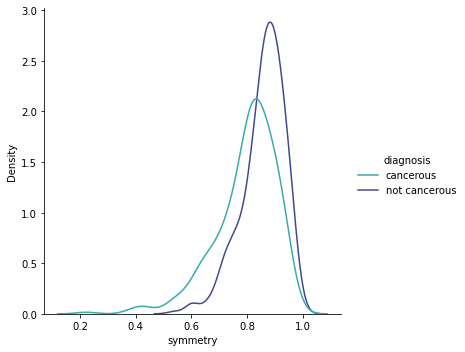

In [35]:
fig = sns.displot(df, x = "symmetry", hue = "diagnosis", kind = "kde", palette="mako_r")
fig.savefig("../figures/symmetry.png")

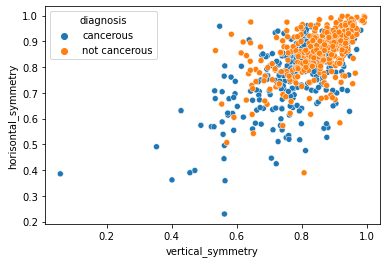

In [36]:
fig2 = sns.scatterplot(x = df["vertical_symmetry"], y = df["horisontal_symmetry"], hue = df["diagnosis"], palette)

In [37]:
fig2.savefig("../figures/scatter_symmetry.png")

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

## For reproducibility (NEED A PROPER DOWNLOAD LINK FOR THE READER)
If the reader wants to reproduce our features, one has to set CALCULATE_FEATURE to be True and has to have the ISIC 2017 dataset downloaded and placed into the data folder.

In [6]:
CALCULATE_FEATURE = True
if CALCULATE_FEATURE:
    #Path to the 2017 data set
    PATH["data_2017"] = "../data/2017/ISIC-2017_Training_Part3_GroundTruth.csv"
    PATH["data_2017_image"] = "../data/2017/ISIC-2017_Training_Data/{}.jpg"
    PATH["data_2017_segmentation"] = "../data/2017/ISIC-2017_Training_Part1_GroundTruth/{}_segmentation.png"

    dataframe = pd.read_csv(PATH["data_2017"])

In [7]:
#Test run
dataframe

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


## Functions

### Plotting the testing of parameters in ML classifiers

In [100]:
def plot_test_ML(validation_acc, validation_auc, training_acc, training_auc, xlabel):
    fig, ax = plt.subplots(2,2,figsize=(13,4))
    ax[0,0].set_title("validation accuracy")
    ax[0,0].plot(range(1,len(validation_acc)+1), validation_acc);
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel("accuracy");


    ax[0,1].set_title("validation roc_auc accuracy")
    ax[0,1].plot(range(1,len(validation_acc)+1), validation_auc)
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel("accuracy");

    ax[1,0].set_title("training accuracy")
    ax[1,0].plot(range(1,len(validation_acc)+1), training_acc);
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel("accuracy");


    ax[1,1].set_title("training roc_auc accuracy")
    ax[1,1].plot(range(1,len(validation_acc)+1), training_auc)
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel("accuracy");
    fig.tight_layout()

### Calculation of the symmetric feature

In [101]:
def crop_to_lesion(picture, segment):
    """
    "Zooms" in on the lesion, meaning it cuts away everything else
    
    Takes a picture and it's corresponding mask/segment
    Returns the picture and the segment, cropped to only the lesion 
    """
    
    height = segment.shape[0]
    width = segment.shape[1]
       
    img_df = pd.DataFrame(segment)    
    
    x_1 = x_2 = 0
    y_1 = y_ = 0
    
    #Iterating over all the columns finding the first column that has a white pixel
    for i in range(width):
        if list(img_df[i]).count(1.0) > 0:
            x_1 = i
            break
        else:
            continue
            
    #Iterating over all the columns backwards finding the first column that has a white pixel
    for i in range(width):
        if list(img_df[(width-1) - i]).count(1.0) > 0:
            x_2 = ((width-1) - i)
            break
        else:
            continue   
    
    
    #Iterating over all the rows finding the first row that has a white pixel
    for i in range(height):
        if list(img_df.loc[i]).count(1.0) > 0:
            y_1 = i
            break
        else:
            continue   
    
    #Iterating over all the rows backwards finding the first row that has a white pixel
    for i in range(height):
        if list(img_df.loc[(height-1) - i]).count(1.0) > 0:
            y_2 = ((height-1) - i)
            break
        else:
            continue
    
    img_part = picture[y_1:y_2,x_1:x_2]
    segment_part = segment[y_1:y_2,x_1:x_2]
    
    return (img_part, segment_part)

In [102]:
def rescale_img(segment, scale):
    """
    Rescales an image so it has the width of the scale
    
    Takes a segment/mask
    Returns the segment/mask rescaled to have the width of the scale
    """
    
    width = segment.shape[1]
        
    cut_rescaled_segment = skimage.transform.rescale(segment, scale/width, anti_aliasing=False)
    
    return cut_rescaled_segment

In [103]:
def edge_points(segment):
    """
    Finds all the coordinates to the points which lie on the edge of the lesion. 
    This function creates an identical image to the segment only one pixel smaller. Then subtracts the segment 
    with the smaller segment and we are left with only the border. It then goes through all the white pixels left and maps it.
    
    Takes a segment
    Returns a list with the coordinates to all the edge points
    
    """
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(segment, struct_el)
    image_perimeter = segment - mask_eroded
    
    height = segment.shape[0]
    width = segment.shape[1]
    
    perimeter_df = pd.DataFrame(image_perimeter)
    
    coords = []
    
    for i in range(width):
        for val, j in zip(perimeter_df[i], range(len(perimeter_df[i]))):
            if val == 1.0:
                coords.append((i,j))
                
    return coords

In [104]:
def longest_diameter(segment):
    """
    Calculates the longest distance among all the edge points. Takes quadratic time since it has to calculate the distance
    from all the coordinates to all the coordinates.
    
    Takes a segment
    Returns the longest distance, and the two coordinates that makes the longest distance
    """
    edge_coords = edge_points(segment)
    dist = {}
    
    for coord, i in zip(range(len(edge_coords)),edge_coords):
        dist.update({coord:[]})
        for coord2,j in zip(range(len(edge_coords)),edge_coords):
            length = edge_coords[coord][1] - edge_coords[coord2][1]
            width = edge_coords[coord][0] - edge_coords[coord2][0]
            dist[coord].append(((round(((length**2+width**2)**0.5),2)),(i,j)))
            
    #creates a list of only the longest coordinate pair for every coordinate
    coordinates_max = [max(dist[key]) for key in dist]
    #Returns only the max of the list
    return max(coordinates_max)

In [105]:
def tilt_image(segment):
    """
    Rotates a segment so it's longest diameter is vertical
    Takes a long time if run with a normal picture that has not been rescaled.
    
    Takes a segment
    Returns the segment so it is vertical
    """
    length, coord = longest_diameter(segment)
    xy1 = coord[0]
    xy2 = coord[1]
    
    v1 = (xy2[0]-xy1[0], xy2[1]-xy1[1])
    v2 = (0,100)
    
    angel = 180-math.degrees(math.acos((v1[0]*v2[0]+v1[1]*v2[1])/(math.sqrt(v1[0]**2+v1[1]**2)*math.sqrt(v2[0]**2+v2[1]**2))))                       

    rot_im = skimage.transform.rotate(segment, 360-angel)
    return rot_im

In [106]:
def symmetric(seg, plot = False):
    """
    Calculates how "symmetric" a segment is. It flips the picture 180 degrees mirrors it and subtracts
    it from the original. This is done both vertically and horisontally. The closer to 1 the return value is, the more
    symmetric the lesion is
    
    Takes a segment
    Returns the vertical and horisontal symmetry (between 0 and 1)
    """
    
    rescaled_img = rescale_img(seg, 500)
    tilted_img = tilt_image(rescaled_img)
    vertical_seg = crop_to_lesion(seg, tilted_img)[1]
    
    #Vertical difference    
    vertical_rot_180 = skimage.transform.rotate(vertical_seg, 180)
    vertical_flip = vertical_rot_180[:, ::-1]
    
    vertical_asymmetric_pixels = vertical_seg - vertical_flip
    
    white = len(vertical_asymmetric_pixels[vertical_asymmetric_pixels == 1.0])
    black = len(vertical_asymmetric_pixels[vertical_asymmetric_pixels == -1.0])
    vertical_asymmetry = black+white
    
    if plot == True:
        #Plot the difference
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
        axes[0].imshow(vertical_seg, cmap = "gray")
        axes[1].imshow(vertical_flip, cmap='gray')
        axes[2].imshow(vertical_asymmetric_pixels, cmap = "gray")
    
    #Horisontal difference
    rot_90 = skimage.transform.rotate(tilted_img, 90) 
    rescaled_seg = crop_to_lesion(seg, rot_90)[1]   
    rot_180 = skimage.transform.rotate(rescaled_seg, 180)
    
    flip = rot_180[:, ::-1]
    
    asymmetric_pixels = rescaled_seg - flip
    
    white = len(asymmetric_pixels[asymmetric_pixels == 1.0])
    black = len(asymmetric_pixels[asymmetric_pixels == -1.0])
    horisontal_asymmetry = black+white
        
    if plot == True:
        #Plot the difference
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
        axes[0].imshow(rescaled_seg, cmap = "gray")
        axes[1].imshow(flip, cmap='gray')
        axes[2].imshow(asymmetric_pixels, cmap = "gray")
    
    total = len(vertical_seg[vertical_seg == 1.0])
    
    #Checks for negative values
    vertical_symmetry = 1 - (vertical_asymmetry/total)
    if vertical_symmetry < 0:
        vertical_symmetry = vertical_symmetry*(-1)
    
    horisontal_symmetry = 1 - (horisontal_asymmetry/total)
    if horisontal_symmetry < 0:
        horisontal_symmetry = horisontal_symmetry*(-1)
    
    return (vertical_symmetry, horisontal_symmetry)

### Calculation of the color features

In [107]:
def image_segmentation(original, segmentation):
    """takes an image and the corresponding segmentation and returns the image "masked" to only show the lesion"""
    ori_img = plt.imread(original)
    seg_img = plt.imread(segmentation)

    segmented_image = ori_img.copy()
    segmented_image[seg_img==0] = 0

    return segmented_image

In [108]:
def measure_color(original, segmentation):
    """Input: the original and the segmentation file
    Return: 
    [0] relative_color_variance, meaning the number of unique RGB-values in the lesion / the total of pixels the lesion make up
    [1:4] the average of R, G and B value individually
    [4:7] the standard deviation of R, G and B individually
    [7] average standard deviation
    [8:11] range of R, G and B individually
    [11:14] Percentage of R, G and B values out of the total values
    [14] ratio of r-values below 50 out of the total of r-values
    [15] ratio of b-values above 150 out of the total of b-values
    [16] all RGB_values
    """
    # getting the "masked" image and transforming it from array to Image
    image = Image.fromarray(image_segmentation(original, segmentation).astype('uint8'), 'RGB')
    
    # all colors in lesion
    width, height = image.size
    pixels = image.getcolors(width*height) # getting the colors of the shape of the image
    sorted_pixels = sorted(pixels, key=lambda t: t[0], reverse=True) # sorting found pixels by count (ascending)
    colors = sorted_pixels[1:] # ignoring the first colour, as it is just the background (black / white)
    
    # 5 dominant colors of lesion
    rgb_values = [list(i[1]) for i in colors] # without the "key"
    dominant_colors = rgb_values[0:5]
    
    # finding total of pixels the lesion make up
    lesion_pixels = [i[0] for i in colors] # taking the "key" from the found colors
    total_lesion_pixels = sum(lesion_pixels) # adding the "keys" together
    
    # number of unique RGB-values relative to total number of pixels the lesion make up
    unique_colors = len(colors)
    relative_color_variance = (unique_colors/total_lesion_pixels)
    
    # average color of lesion
    r_values = [i[0] for i in rgb_values] # assigning each r, g and b to own list
    g_values = [i[1] for i in rgb_values]
    b_values = [i[2] for i in rgb_values]
    
    r_average = int(sum(r_values)/len(r_values)) # taking average of each of those lists
    g_average = int(sum(g_values)/len(g_values))
    b_average = int(sum(b_values)/len(b_values))

    # finding the standard deviation of r, g and b
    r_std = np.std(r_values) # referring back to the previous made list of r, g and b individually
    g_std = np.std(g_values)
    b_std = np.std(b_values)
    
    # finding the average of the standard deviations
    average_std = (r_std + g_std + b_std)/3
    
    # finding the range each R, G and B value has by subtracting the min-value from the max-value of each
    r_range = max(r_values)-min(r_values) # referring back to the previous made list of r, g and b individually
    g_range = max(g_values)-min(g_values)
    b_range = max(b_values)-min(b_values)
    
    # finding the total percentage each R, G and B sums make up of the total sum
    r_sum, g_sum, b_sum = sum(r_values), sum(g_values), sum(b_values)
    total_sum = r_sum + g_sum + b_sum
    r_pct = r_sum/total_sum
    g_pct = g_sum/total_sum
    b_pct = b_sum/total_sum
    
    # finding number of r-values below 50 (which is possibly considered "too low")
    low_r_values = []
    for i in r_values:
        if i < 50:
            low_r_values.append(i)
    r_low = len(low_r_values)/len(r_values) # making it in relation to the number of values
    
    # finding number of b-values above 150 (which is possibly considered "too high")
    high_b_values = []
    for i in b_values:
        if i > 150:
            high_b_values.append(i)
    b_high = len(high_b_values)/len(b_values) # making it in relation to the number of values
    
    return relative_color_variance, r_average, g_average, b_average, r_std, g_std, b_std, average_std, r_range, g_range, b_range, r_pct, g_pct, b_pct, r_low, b_high, colors

In [109]:
# inspiration from: https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [110]:
# inspiration from: https://gist.github.com/Uberi/4885a318e7ef2afa7f22

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

def plot_colors(original, segmentation):
    """Input: the original and the segmentation image.
    Return: Plots the points of the R, G and B values with corresponding colors in 3D"""
    colors = measure_color(original, segmentation)[16]
    colors_list = [list(i[1]) for i in colors]
    
    r = [i[0] for i in colors_list]
    g = [i[1] for i in colors_list]
    b = [i[2] for i in colors_list]

    ashex_list = []
    
    # converting each of the found RGB-values to hex-values and appending these to a new list
    for i in colors_list:
        rr = i[0]
        gg = i[1]
        bb = i[2]
        ashex = ashex_list.append(rgb2hex(rr, gg, bb))
    
    fig = pyplot.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d") # 3D plot with scalar values in each axis
    
    axis.scatter(r, g, b, c = ashex_list, marker="o") # the color become the corresponding from the ashex_list
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue")

    return pyplot.show()

### Calculations of the area, perimeter and radius featues

In [111]:
# find center of lesion
def find_center(img_path):
    borders = np.where(img_path == 1) # This will return 2 arrays with the index where the pixels are ones
    top, bottom, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((top+bottom) //2, (left + right) //2) # Tuple with the coordinates for the center of the lesion
    return center

# find standard deviation and mean of 
def radial_profile(mask):

    center = find_center(mask)

    # Find perimeter: Veronika's code
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded

    # select coordinates for all pixels belonging to the perimeter
    y, x = np.where(np.array(image_perimeter)) 
    # calculate the distance between the center pixel to all pixels in the perimeter
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    sd, mean = np.std(r), np.mean(r)

    return sd, mean

In [112]:
def get_features(df, column):
    '''
    Input: list of image numbers.
    Output: radius standard deviation, radius mean, area, perimeter 
    and compactness (aka roundness) for all images in the list.
    '''
    # get list of all image numbers to iterate
    img_nums_list = list(df[column])

    #initialize list of features
    features = list()

    # create the list will features
    for img_num in img_nums_list:
        im = plt.imread(path_mask + img_num + file_mask)
        area, perimeter = measure_area_perimeter(im)
        radius_sd, radius_mean = radial_profile(im)
        features.append([img_num, radius_sd, radius_mean, area, perimeter])
    
    # turn area and perimiter list into a dataframe
    features_df = pd.DataFrame(features)
    features_df.rename(columns = {1: "radius_sd", 2: "radius_mean", 3: "area", 4: "perimeter"}, inplace=True)
    
    # calculate compactness/roundness
    features_df['compactness'] = (features_df['perimeter']**2)/(4 * math.pi * features_df['area'])

    # merge area and perimeter df with the initial dataframe
    MAIN = pd.merge(df, features_df, how='left', left_on='image_id', right_on=0).drop([0], axis=1)

    # calculate the compactness of each skin lesion
    MAIN['compactness'] = (MAIN['perimeter']**2)/(4 * math.pi * MAIN['area'])

    # create a sum of the diagnosis to find healthy and not healthy skin lesions
    MAIN['diagnosis_sum'] = MAIN['melanoma'] + MAIN['seborrheic_keratosis']

    # add new column with group name, mostly for labeling
    MAIN['diagnosis'] = MAIN['melanoma'].map({0: 'not melanoma', 1: 'melanoma'})

    return MAIN

# Task 0: Inspection of the data

Taking a first look at the example data, shows there are 150 pictures in total. 30 of them are diagnosed with melanoma, 42 are diagnosed with keratosis, the remaining 78 are to be considered healthy.

In [1]:
csv = pd.read_csv(PATH["data_example"])
print("Shape:", csv.shape)
print("Number of lesions with melanoma:", len(csv[csv["melanoma"] == 1.0]))
print("Number of lesions with keratosis:", len(csv[csv["seborrheic_keratosis"] == 1.0]))
print("Number of healthy lesions:", len(csv[(csv["melanoma"] == 0.0) & (csv["seborrheic_keratosis"] == 0.0)]))

NameError: name 'pd' is not defined

Since we are group 8 we are only trying to determine the cancer type melanoma. To only compare healthy lesions and lesions with melaona, we have decided to remove all cases with keratosis. Calculating a feature based on both healthy lesions and lesions with keratosis, would in the end confuse the classifier. To keep everything clean we therefore cut the dataframe to only consist of lesions that are relvant for our project

In [114]:
data_example = data_example[data_example["seborrheic_keratosis"] != 1.0]
data_example

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0
...,...,...,...
145,ISIC_0015443,0.0,0.0
146,ISIC_0015445,0.0,0.0
147,ISIC_0015483,0.0,0.0
148,ISIC_0015496,0.0,0.0


## Inspecting the pictures

From the csv document in the column "image_id" we see that each picture has a unique id. The picuteres and their corresponding segmentation is then found in two folders. To be sure there exists an images and a segmentation to every id,  we check it with the following function.

In [115]:
def check_id(id_list, path_picture, path_segment):
    missing_picture = 0
    missing_segment = 0
    for idd in id_list:
        try:
            np.fromfile(path_picture.format(idd))
        except:
            missing_picture += 1
        
        try:
            np.fromfile(path_segment.format(idd))
        except:
            missing_segment += 1
            
    return ("Missing_pictures:", missing_picture, "Missing segments", missing_segment)

In [116]:
check_id(data_example["image_id"], PATH["data_example_image"], PATH["data_example_segmentation"])

('Missing_pictures:', 0, 'Missing segments', 0)

Since there are no missing images or segments, we can take a look at an image and it's corresponding segmentation. The quality of this is good, and is sufficient for our research.

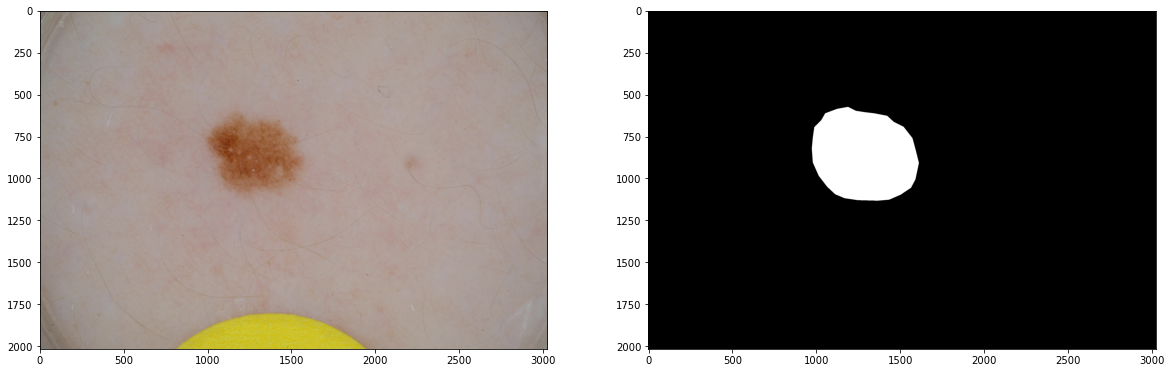

In [117]:
test = data_example["image_id"][20]

img = plt.imread(PATH["data_example_image"].format(test))
segment = plt.imread(PATH["data_example_segmentation"].format(test))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
axes[0].imshow(img)
axes[1].imshow(segment, cmap='gray')

To determine the quality of the pictures we take a look at the first 5 healthy lesions and the first 5 melanoma cancerous lesions in the example files.

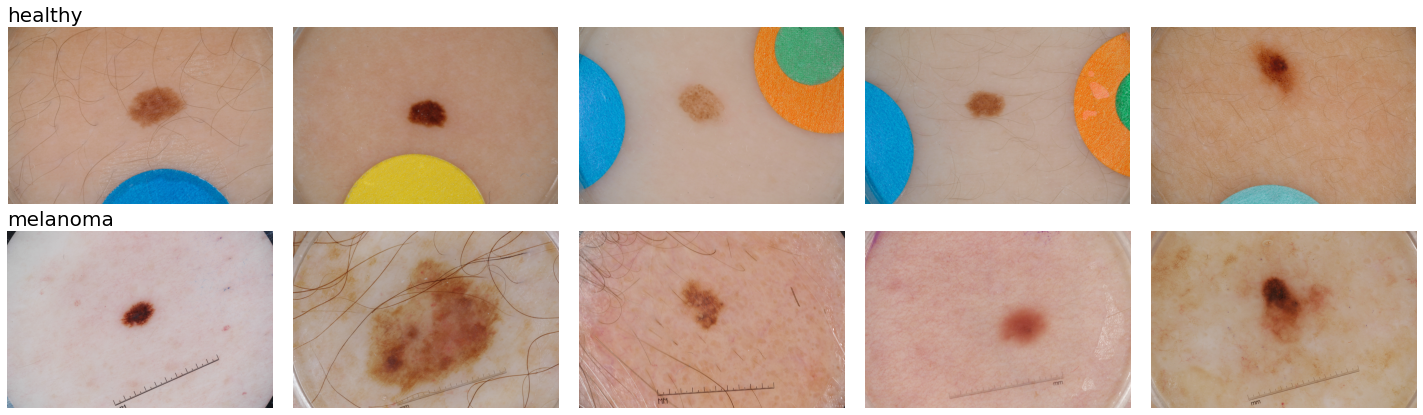

In [118]:
label = [0.0, 1.0]
label_images = []
classes = ['healthy', 'melanoma']

fig = plt.figure(figsize=(20, 20))
k = range(7)

for i in label:
    sample = data_example[data_example['melanoma'] == i]['image_id'][:5]
    label_images.extend(sample)
    
for position, ID in enumerate(label_images):
    labl = data_example[data_example['image_id'] == ID]['melanoma']
    im_sample = example_img_path + f'{ID}.jpg'
    im_sample = plt.imread(im_sample)

    plt.subplot(7, 5, position+1)
    plt.imshow(im_sample)
    plt.axis('off')

    if position%5 == 0:
        title = int(position/5)
        plt.title(classes[title], loc='left', size=20)

plt.tight_layout()
plt.show()

The pictures have a good quality, and is sufficient for our research.

## For reproduceability: Manipulating the 2017 dataset

The 2017 dataset consists, just like the example dataset, of two folders with pictures and corresponding segments and a csv file that binds pictures and segments together with and ID. The set consists of 2000 lesions and there are again three options for a lesion, it can either have melanoma, keratosis or be healthy. What has been shown above for task 0 has also been repeated for this dataset, but will not be shown here. 

In [119]:
print(dataframe.shape)
print("Number of lesions with Melanoma:", len(dataframe[dataframe["melanoma"] == 1.0]))
print("Number of lesions with Keratosis:", len(dataframe[dataframe["seborrheic_keratosis"] == 1.0]))
print("Number of healthy lesions:", len(dataframe[(dataframe["melanoma"] == 0.0) & (dataframe["seborrheic_keratosis"] == 0.0)]))

(5, 3)
Number of lesions with Melanoma: 2
Number of lesions with Keratosis: 0
Number of healthy lesions: 3


In [120]:
#Removes the lesions with keratosis
dataframe = dataframe[dataframe["seborrheic_keratosis"] != 1.0]
dataframe

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


In [121]:
# this is how i did it so pasting it here, feel free to delete if not needed Rasmus - Sabrina
raw = pd.read_csv('../data/2017/ISIC-2017_Training_Part3_GroundTruth.csv')
raw_df = pd.DataFrame(raw)
melanoma = raw_df[raw_df['melanoma'] == 1]
keratosis = raw_df[raw_df['seborrheic_keratosis'] == 1]
healthy = raw_df.loc[(raw_df['melanoma'] == 0) & (raw_df['seborrheic_keratosis'] == 0)]
# healthy_balanced = healthy.iloc[:melanoma.shape[0],:]

m_h = melanoma.append(healthy) # melanoma and healthy only
m_h_k = m_h.append(keratosis) # all

Loading of the files with feateures by different group memebers.

In [ ]:
colours = pd.read_csv('../data/all_color_measurements.csv')
colours = colours.drop(['Unnamed: 0', 'melanoma', 'diagnosis'], axis=1)
print(colours.shape)

sym = pd.read_csv('../data/sym_col.csv')
sym = sym.iloc[:,np.r_[1,7:10]]
print(sym.shape)

radius = pd.read_csv('../data/processed/final_unbalanced.csv')
print(radius.shape)

Merging all calculated funtions into the final dataframe.

In [ ]:
final = pd.merge(radius, sym, how='left', left_on='image_id', right_on='image_id')
final = pd.merge(final, colours, how='left', left_on='image_id', right_on='image_id').sort_values(by='image_id')
final

# Task 1: Implement two features

## The symmetry of a lesion

A for Asymmetry, is the first sign to look for in the ABCDE's of melanoma. Cancerous lesions tend to not have perfect symmetric shapes, therefore if you draw a line through the lesion, then the two halves won't match. To measure this feature on a lesion, we have come up with an algorithm that turns and flips a segment/mask of a given lesion and calculates how much mass lies outsides of the original boundaries. This is done two times, both for the vertical symmetry and the horisontal symmetry. <br>
<br>
To reduce computation time all images are rescaled largely. We can do this with confidence for this feature, because we are only interested in the shape of the lesion and not the original size. Down to a certian degree, shapes are almost not altered be rescaling. Thus making our code faster without us loosing critical information about the lesion.

To explain how the algorithm works, a toy example with a triangle is shown. N.B: It is not shown here, but our algorithm aslo makes sure that the lesion in the first place is turned so the longest diameter is vertical


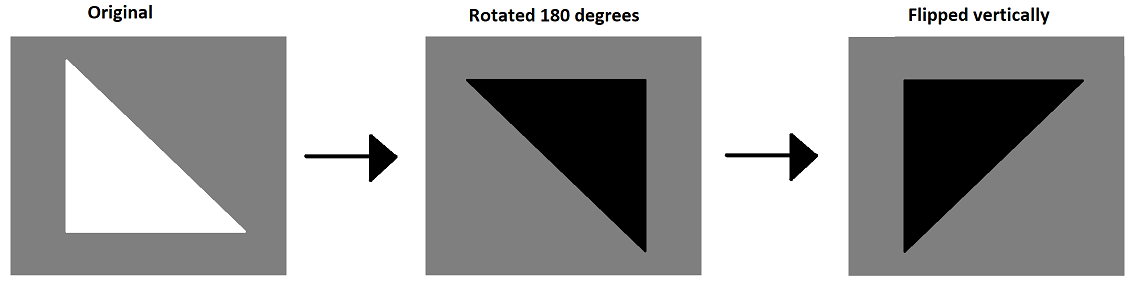

The algorithm is fed a segment/mask. A copy is made, and that picture is turned 180 degrees and flipped vertically. This is essentially the same as "folding" the segment on the middle, and calculating overlapping pixels. In our way, we do two "folds" simultaneously and therefore only have to do two calculations instead of four. To calculate the horisontal assymetry the picture is just rotated 90 degrees first, and then the above steps is copied. 

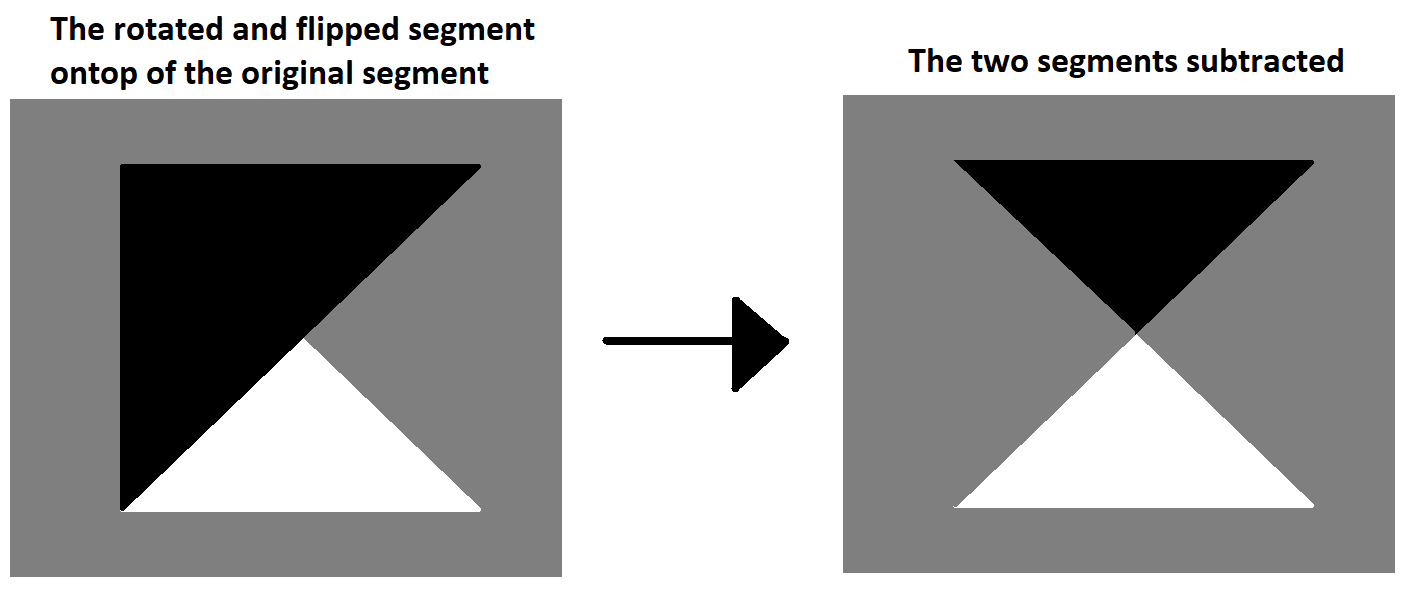

The original segment and the turned + flipped segments is then subtracted from eachother. This results in an image consisting of pixels in either gray, black or white. This happens because we are subtracting two pictures only consisting of the color codes 0 or 1. When doing so four things can happen mathematically:

The two subtracted elements are both empty <br>
0 - 0 = 0 (gray)<br>
<br>
Matter is being subtracted from something empty <br>
0 - 1 = -1 (black)<br>
<br>
Something empty is being subtracted from matter <br>
1 - 0 = 1 (white)<br>
<br>
Matter is being subtracted from matter <br>
1 - 1 = 0 (gray)

The amount of black and white pixels are then summed up, this is the amount of assymetric pixels. The assymetric pixels are then divied by the total amount of white pixels in the original segment/mask. This shows the relative amount of asymmetric pixels. However, we wanted our feature to show how symmetric the lesion is and not how assymetric it is. To do this we subtract the relative amount of symmetric pixels from 1. Meaning the more symmetric a lesion is, the closer to 1 this algorithm will label it.

### Example

(0.658728302063351, 0.7141252982735227)

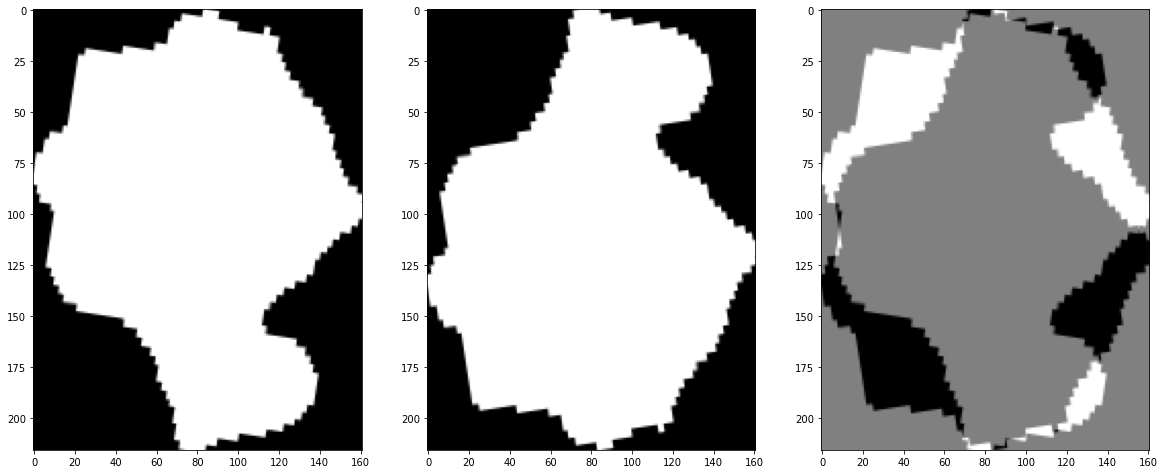

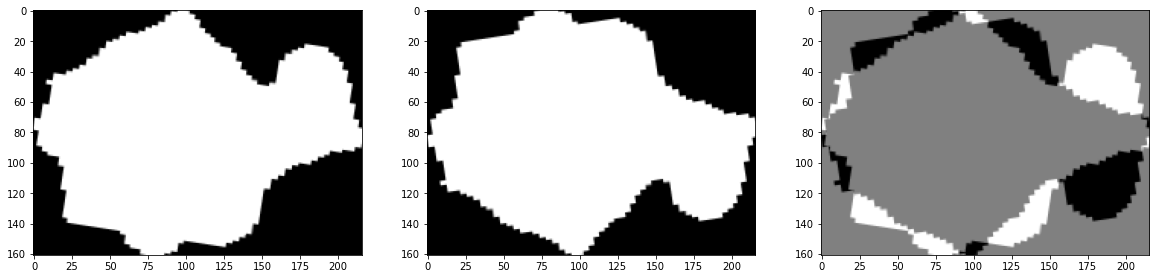

In [122]:
seg = plt.imread("../data/example_segmentation/ISIC_0012210_segmentation.png")
symmetric(seg, True)

The symmetry is then calculated for every image in our data. The code below runs through all id's in the dataframe and calculates the symmetry. Takes about 15 minutes for all the pictures in our dataset. Lastly the vertical symmetry and the horisontal symmetry is added to the dataframe along with an extra column consisting of the average symmetry.

#### Run this code to reproduce the color feature (takes around 15 min to go through the 2017 dataset)

In [129]:
if CALCULATE_FEATURE:
    vertical_symmetry = []
    horisontal_symmetry = []

    for idd in list(dataframe["image_id"]):
        seg = plt.imread(PATH["data_2017_segmentation"].format(idd))
        V, H = symmetric(seg)
        vertical_symmetry.append(V)
        horisontal_symmetry.append(H)

    dataframe["vertical_symmetry"] = vertical_symmetry
    dataframe["horisontal_symmetry"] = horisontal_symmetry
    dataframe["symmetry"] = (dataframe["vertical_symmetry"]+dataframe["horisontal_symmetry"])/2

In [130]:
dataframe

,image_id,melanoma,seborrheic_keratosis,vertical_symmetry,horisontal_symmetry,symmetry
0,ISIC_0000000,0.0,0.0,0.852509,0.905879,0.879194
1,ISIC_0000001,0.0,0.0,0.864663,0.917303,0.890983
2,ISIC_0000002,1.0,0.0,0.897238,0.932438,0.914838
3,ISIC_0000003,0.0,0.0,0.828387,0.876698,0.852543
4,ISIC_0000004,1.0,0.0,0.922531,0.861041,0.891786


## The border of a lesion
B for Border, is the second sign to look for in the ABCDE's of melanoma.As boarder irregularity is an indicator of melanoma we implemented the `radius_sd` feature by first finding the center of the lesion, then measuring the distance around all pixels in the perimer and saving them into a list. From the list we calculated the mean and the standard deviation of the lesion. 

From the plot below we can see an inidcation that this is indeed a good predictor of melanoma from the clear separatino in the distributions.

In [ ]:
# add plot here
# also add smth about normalising the data
# and scaling issues?

## The color of a lesion
C for Color, is the third sign to look for in the ABCDE's of melanoma. Normal moles are generally a uniform tan, brown or black color, while cancerous lesions tend to consist of many colors or an uneven distribution of color. An indicator of cancer can also be a change of color of the lesion. <br>
<br>
The original images and the corresponding segmentation image is overlapped to mask the original image to only show the lesion, leaving the rest black. See the function <code>image_segmentation</code>.<br>
This mask is then used to measure the color of all pixels in the lesion, meaning the RGB-value of each and every pixel in the lesion is found and each unique RGB-value counted. These are then used to find various indicator of variation in color:
<li> <code>measure_color[0]</code> returns the relative color variance, meaning the number of unique RGB-values in the lesion devided with the number of total pixels the lesion make up.</li>
<li> <code>measure_color[1:4]</code> returns the average of the R, G and B values found in the lesion.</li>
<li> <code>measure_color[4:7]</code> returns the standard deviation of the R, G and B values found in the lesion.</li>
<li> <code>measure_color[7]</code> returns the average of the standard deviations found of each R, G and B values.</li>
<li> <code>measure_color[8:11]</code> returns the range the R, G and B values found in the lesion span over.</li>
<li> <code>measure_color[11:14]</code> returns the percentage the R, G and B values found in the lesion each make up of the total values.</li>
<li> <code>measure_color[14]</code> returns the ratio of r-values found in the lesion that is below 50 in relation to the total number of r-values of the lesion.</li>
<li> <code>measure_color[15]</code> returns the ratio of b-values found in the lesion that is above 150 in relation to the total number of b-values of the lesion.</li>
<li> <code>measure_color[16]</code> all unique RGB-values found in the lesion and the corresponding number of pixels it was found in. </li>
<br><br>
Some measurement are already normalized, while some will be later.<br><br>
To explore the color distribution of healthy and melanoma lesions the <code>plot_colors</code>-function plots the RGB-values in a 3D plot with the plots having the corresponding color to the value.<br>


The input images before-hand could have been cropped to primarly only show the lesion and then all been given the same dimensions, but instead the different pixel measurements have been calculated with the total amount of pixels found in the lesion in mind to get a somewhat even distribution regardless of this. Including the cropping of the image before hand was found to worsen the running time of the code. 

### Example: Visualizing

In [ ]:
melanoma_img, melanoma_seg = '../data/example_image/ISIC_0014931.jpg', '../data/example_segmentation/ISIC_0014931_segmentation.png'
print(plot_colors(healthy_img, healthy_seg))
print(plot_colors(melanoma_img, melanoma_seg))

The melanoma lesion has clearly a bigger range of color than the healthy lesion. Regardless of the size the lesion take up of the image.

### Example: Measurements

In [ ]:
healthy_img, healthy_seg = '../data/example_image/ISIC_0001769.jpg', '../data/example_segmentation/ISIC_0001769_segmentation.png'
print("Relative color variance:", measure_color(healthy_img, healthy_seg)[0])
print("Average R, G and B values:", measure_color(healthy_img, healthy_seg)[1:4])
print("Standard deviation of R, G and B:", measure_color(healthy_img, healthy_seg)[4:7])
print("Average of the standard deviation:", measure_color(healthy_img, healthy_seg)[7])
print("Range of R, G and B:", measure_color(healthy_img, healthy_seg)[8:11])
print("Percentage of R, G and B values:", measure_color(healthy_img, healthy_seg)[11:14])
print("Ratio of r-values below 50:", measure_color(healthy_img, healthy_seg)[14])
print("Ratio of b-values above 150:", measure_color(healthy_img, healthy_seg)[15])

The different color measurements is then calculated for every image in our data. The code below runs through all id's in the dataframe and calculates the color. Takes about 15 minutes for all the pictures in our dataset. Lastly the results is normalized (if not already) and added to the dateframe.

In [ ]:
if CALCULATE_FEATURE: 
    relative_color_variance = []
    r_average = []
    g_average = []
    b_average = []
    r_std = []
    g_std = []
    b_std = []
    average_std = []
    r_range = []
    g_range = []
    b_range = []
    r_pct = []
    g_pct = []
    b_pct = []
    r_low = []
    b_high = []

    for i in dataframe['image_id']:
       rel_col_var, r_avg, g_avg, b_avg, r_sd, g_sd, b_sd, avg_std, r_ran, g_ran, b_ran, r_pc, g_pc, b_pc, low_r, high_b = measure_color(f'{path_img}{i}.jpg', f'{path_seg}{i}_segmentation.png')[0:16]
       relative_color_variance.append(round(rel_col_var, 4))
       r_average.append(round(r_avg, 4))
       g_average.append(round(g_avg, 4))
       b_average.append(round(b_avg, 4))
       r_std.append(round(r_sd, 4))
       g_std.append(round(g_sd, 4))
       b_std.append(round(b_sd, 4))
       average_std.append(round(avg_std, 4))
       r_range.append(round(r_ran, 4))
       g_range.append(round(g_ran, 4))
       b_range.append(round(b_ran, 4))
       r_pct.append(round(r_pc, 4))
       g_pct.append(round(g_pc, 4))
       b_pct.append(round(b_pc, 4))
       r_low.append(round(low_r, 4))
       b_high.append(round(high_b, 4))

In [ ]:
if CALCULATE_FEATURE: 
    # normalizing average R, G and B
    norm_r_average = [(i-min(r_average))/(max(r_average)-min(r_average)) for i in r_average]
    norm_g_average = [(i-min(g_average))/(max(g_average)-min(g_average)) for i in g_average]
    norm_b_average = [(i-min(b_average))/(max(b_average)-min(b_average)) for i in b_average]

    # normalizing std of R, G and B
    norm_r_std = [(i-min(r_std))/(max(r_std)-min(r_std)) for i in r_std]
    norm_g_std = [(i-min(g_std))/(max(g_std)-min(g_std)) for i in g_std]
    norm_b_std = [(i-min(b_std))/(max(b_std)-min(b_std)) for i in b_std]
    norm_average_std = [(i-min(average_std))/(max(average_std)-min(average_std)) for i in average_std]

    # normalizing average R, G and B
    norm_r_range = [(i-min(r_range))/(max(r_range)-min(r_range)) for i in r_range]
    norm_g_range = [(i-min(g_range))/(max(g_range)-min(g_range)) for i in g_range]
    norm_b_range = [(i-min(b_range))/(max(b_range)-min(b_range)) for i in b_range]

In [ ]:
# adding to dataframe
if CALCULATE_FEATURE:
    dataframe['relative_color_variance'] = relative_color_variance
    dataframe['r_average'] = norm_r_average
    dataframe['g_average'] = norm_g_average
    dataframe['b_average'] = norm_b_average
    dataframe['r_std'] = norm_r_std
    dataframe['g_std'] = norm_g_std
    dataframe['b_std'] = norm_b_std
    dataframe['average_std'] = norm_average_std
    dataframe['r_range'] = norm_r_range
    dataframe['g_range'] = norm_g_range
    dataframe['b_range'] = norm_b_range
    dataframe['r_pct'] = r_pct
    dataframe['g_pct'] = g_pct
    dataframe['b_pct'] = b_pct
    dataframe['r_low'] = r_low
    dataframe['b_high'] = b_high
dataframe

# Task 2: Predict the diagnosis
Split your data so that you are have training data and hold-out test data. Use
the training data to train different classifiers and investigate their parameters.
Once you made a choice, evaluate your classifier on the hold-out test data. Think
of different metrics you can use, and different ways to present your results.

Splitting data into development and test data using the train_test_split function from sklearn.model_selection.
Then we split the development data into a validation set and a training set.
Here we decide to only have our model(s) train on a lot of features, such as area, perimeter, compactness and symmetry.

We set the random state to be 42, to get reproducibility in our results
we also set the test size to be 0.2, so that means that our test data is 20% of our raw data. The remaining 80% our model is going to train and validate on.

In [ ]:
non_balanced_df

In [ ]:
df = non_balanced_df
features = df.drop(["image_id", "melanoma", "seborrheic_keratosis", "diagnosis_sum", "diagnosis"], axis = 1)
X_dev, X_test, y_dev, y_test = train_test_split(features, df["melanoma"], stratify=df["melanoma"], random_state=42,test_size=0.8)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify=y_dev, random_state=42, test_size=0.8)

## Feature selection

Train a class for k best features, may be errors here since, the class will pick the highest scores of which can be correlated features, since they will have almost the same score, which then will not result in poor results.

In [ ]:
selector = SelectKBest(mutual_info_classif, k=3)
selector.fit(X_train, y_train)

Then we ascess the scores and plot them

In [ ]:
scores = selector.scores_
plt.bar(features.columns, scores, label=r'Feature score')
plt.xticks(rotation=90);

In [ ]:
sorted(zip(selector.scores_, features.columns), reverse=True)[:10]

In [ ]:
X_train = X_train[["area","relative_color_variance", "radius_mean"]]
X_test = X_test[["area","relative_color_variance", "radius_mean"]]
X_val = X_val[["area","relative_color_variance", "radius_mean"]]

Here we see that area, relative_color_variance and radius_mean is scored the highest, these features are not correlated, so we can go through with this.

Initialize, score dictionaryes to store the results from the different classifier tests

In [ ]:
val_acc_score = {}
val_auc_score = {}
train_acc_score = {}
train_auc_score = {}
test_auc_scores = {}
test_acc_scores = {}

## k-nearest neighbors

Run multiple KNN fits, to find the best parameter

In [ ]:
non_balanced_df.shape
non_balanced_df["melanoma"].value_counts()

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    val_predict = knn.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = knn.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

plot_test_ML(val_acc, val_auc, train_acc, train_auc, "n_neighbors")

- A low value of k would mean that noise will have a higher influence on the result
- A large k value will make the predicting computationally expensive. 

Here we decide to go for n_neighbors=8, since it is fairly accurate at that number of neighbors, and it is also not overfitted. Which is exactly what we want.

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=8)
KNN.fit(X_train, y_train)

val_prediction = KNN.predict(X_val)
val_acc_scores["KNN"] = accuracy_score(y_val, val_prediction)
val_auc_scores["KNN"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["KNN"], val_auc_scores["KNN"]))

Here we train the KNN with our training data, we predict using our test data in the trained KNN and we get an accuracy_score for this KNN on our test data.

We see the simple accuracy_score is a lot higher than the roc_accuracy score, which is because the roc_accuracy score checks how accurate our model is to predict positive cases, and we see that it performs poorly. This could be caused by the skewness in our data, we have a lot more healthy lesions than we do cancerous, which would make our model better at prediction healthy. We then assume that the model predicts basically all lesions to be healthy, and thus gets a high accuracy score. In certain cases it predicts the lesion to be cancerous if it is really sure.  

One could also test a randomly picked sample in our data, and we test whether it has cancer or not.

In [ ]:
print(KNN.predict(pd.DataFrame(df.iloc[1742][['area', 'relative_color_variance', 'radius_mean']]).T))

The KNN model predicts this lesion to be 1 [cancerous]

In [ ]:
pd.DataFrame(df.iloc[1742]).T

Though when we find the lesion in our data, it was diagnosed to be non cancerous. Now this is because our KNN has an accuracy score of 0.6, so the model will be wrong in roughly 6/10 cases.

## Decision Tree Classifier

Run multiple Decision Tree Classifier fits, to find the best parameter

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    DTC = DecisionTreeClassifier(random_state=42, max_depth=i)
    DTC.fit(X_train, y_train)
    
    val_predict = DTC.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = DTC.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "max_depth")

Here we have two options, we can go for a very simple Decision Tree, meaning low depth or we could go with a complex, meaning a high depth.  
We decide to go for max depth 30, since the model converges around 25 and the model will not be overfitted, which we see on the validation data.

In [ ]:
DTC = DecisionTreeClassifier(random_state=42, max_depth=30)
DTC.fit(X_train, y_train)
val_prediction = DTC.predict(X_val)
val_acc_scores["DTC"] = accuracy_score(y_val, val_prediction)
val_auc_scores["DTC"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["DTC"], val_auc_scores["DTC"]))

## Random Forest Classifier

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    RFC = RandomForestClassifier(random_state=42, max_depth=i)
    RFC.fit(X_train, y_train)
    
    val_predict = RFC.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = RFC.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "max_depth")

Here we again go for a high depth for high accuracy.

In [ ]:
RFC = RandomForestClassifier(max_depth=40, random_state=42)
RFC.fit(X_train, y_train)
val_prediction = RFC.predict(X_val)
val_acc_scores["RFC"] = accuracy_score(y_val, val_prediction)
val_auc_scores["RFC"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["RFC"], val_auc_scores["RFC"]))

## C-Support Vector Classification

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    SV = SVC(C=i, random_state=42)
    SV.fit(X_train, y_train)
    
    val_predict = SV.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = SV.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "C Value")

In [ ]:
# https://www.quora.com/How-can-I-choose-the-parameter-C-for-SVM
# How do we want to choose our C?

In [ ]:
SV = SVC(random_state=42) 
SV.fit(X_train, y_train)
val_prediction = SV.predict(X_val)
val_acc_scores["SV"] = accuracy_score(y_val, val_prediction)
val_auc_scores["SV"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["SV"], val_auc_scores["SV"]))

## Logistical Regression

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    LR = LogisticRegression(C=i, random_state=42)
    LR.fit(X_train, y_train)
    
    val_predict = LR.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = LR.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "C Value")

Here we see the penalty term C, does not change anything in the classifier, therefore we just use the basic, no parameter changes LogisticRegression from SKlearn

In [ ]:
LR = LogisticRegression(random_state=42)
LR.fit(X_train, y_train)
val_prediction = LR.predict(X_val)
val_acc_scores["LR"] = accuracy_score(y_val, val_prediction)
val_auc_scores["LR"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["LR"], val_auc_scores["LR"]))

## Balanced data

We assume that the reason that our roc_auc score is so low in the preceding sections is because of the ratio between healthy and melanoma cases in the data. It would make the model far better at classifying healthy lesions compared to cancerous lesions. It could also make the model become a "lazy" model in the sense that it just predicts everything to be healthy, and thus gets a high accuracy score, but low roc_auc score

Therefore we check whether having a balanced data, meaning the ratio between healthy and cancerous lesions is 1:1, and we do the exact same as before. This is only done to try and achieve higher accuracy.

Disclaimer: the regular accuracy score will be equal to the roc_auc score when the data is balanced

In [ ]:
balanced = pd.read_csv(PATH["balanced_data_melanoma"])

We see that the data is indeed balanced

In [ ]:
balanced.shape
balanced["melanoma"].value_counts()

In [ ]:
df = balanced
features = df.drop(["image_id", "melanoma", "seborrheic_keratosis", "diagnosis_sum", "diagnosis"], axis = 1)
X_dev, X_test, y_dev, y_test = train_test_split(features, df["melanoma"], stratify=df["melanoma"], random_state=42,test_size=0.8)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify=y_dev)

### k-nearest neighbors

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for k in range(1,26):
    knn_balanced = KNeighborsClassifier(n_neighbors=k)
    knn_balanced.fit(X_train, y_train)
    
    val_predict = knn_balanced.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = knn_balanced.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

plot_test_ML(val_acc, val_auc, train_acc, train_auc, "n_neighbors")

In [ ]:
KNN_balanced = KNeighborsClassifier(n_neighbors=8)
KNN_balanced.fit(X_train, y_train)

val_prediction = KNN_balanced.predict(X_val)
val_acc_scores["KNN_balanced"] = accuracy_score(y_val, val_prediction)
val_auc_scores["KNN_balanced"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["KNN_balanced"], val_auc_scores["KNN_balanced"]))

### Decision Tree Classifier

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    DTC_balanced = DecisionTreeClassifier(random_state=42, max_depth=i)
    DTC_balanced.fit(X_train, y_train)
    
    val_predict = DTC_balanced.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = DTC_balanced.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "max_depth")

In [ ]:
DTC_balanced = DecisionTreeClassifier(random_state=42, max_depth=30)
DTC_balanced.fit(X_train, y_train)
val_prediction = DTC_balanced.predict(X_val)
val_acc_scores["DTC_balanced"] = accuracy_score(y_val, val_prediction)
val_auc_scores["DTC_balanced"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["DTC_balanced"], val_auc_scores["DTC_balanced"]))

### Random Forest Classifier

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    RFC_balanced = RandomForestClassifier(random_state=42, max_depth=i)
    RFC_balanced.fit(X_train, y_train)
    
    val_predict = RFC_balanced.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = RFC_balanced.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "max_depth")

In [ ]:
RFC_balanced = RandomForestClassifier(max_depth=40, random_state=42)
RFC_balanced.fit(X_train, y_train)
val_prediction = RFC_balanced.predict(X_val)
val_acc_scores["RFC_balanced"] = accuracy_score(y_val, val_prediction)
val_auc_scores["RFC_balanced"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["RFC_balanced"], val_auc_scores["RFC_balanced"]))

### C-Support Vector Classification

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    SV = SVC(C=i, random_state=42)
    SV.fit(X_train, y_train)
    
    val_predict = SV.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = SV.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "C Value")

In [ ]:
SV_balanced = SVC(random_state=42) 
SV_balanced.fit(X_train, y_train)
val_prediction = SV_balanced.predict(X_val)
val_acc_scores["SV_balanced"] = accuracy_score(y_val, val_prediction)
val_auc_scores["SV_balanced"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["SV_balanced"], val_auc_scores["SV_balanced"]))

### Logistical regression

In [ ]:
val_acc, val_auc, train_acc, train_auc = [], [], [],[]
for i in range(1,40):
    LR_balanced = LogisticRegression(C=i, random_state=42)
    LR_balanced.fit(X_train, y_train)
    
    val_predict = LR_balanced.predict(X_val)
    val_acc.append(accuracy_score(y_val, val_predict))
    val_auc.append(roc_auc_score(y_val, val_predict))
    
    train_predict = LR_balanced.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_predict))
    train_auc.append(roc_auc_score(y_train, train_predict))

 
plot_test_ML(val_acc, val_auc, train_acc, train_auc, "C Value")

In [ ]:
LR_balanced = LogisticRegression(random_state=42)
LR_balanced.fit(X_train, y_train)
val_prediction = LR_balanced.predict(X_val)
val_acc_scores["LR_balanced"] = accuracy_score(y_val, val_prediction)
val_auc_scores["LR_balanced"] = roc_auc_score(y_val, val_prediction)

print("accuracy: {}\nroc_accuracy: {}".format(val_acc_scores["LR_balanced"], val_auc_scores["LR_balanced"]))

## Specificity and sensitivity

In [ ]:
specificity = {}
sensitivity = {}

In [ ]:
classifiers = [KNN, DTC, RFC, SV, LR, 
               KNN_balanced, DTC_balanced, RFC_balanced,SV_balanced,LR_balanced]
classifier_strings = ["KNN", "DTC", "RFC", "SV", "LR",
                      "KNN_balanced", "DTC_balanced", "RFC_balanced", "SV_balanced", "LR_balanced"]
for i in range(len(classifiers)):
    test_prediction = classifiers[i].predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, test_prediction).ravel()
    specificity[classifier_strings[i]] = tn / (tn+fp)
    sensitivity[classifier_strings[i]] = tp / (tp + fp)

In [ ]:
specificity

In [ ]:
sensitivity

## Conclusion, what do we pick as our classifier?


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(val_auc_scores.keys(), val_auc_scores.values())
ax[1].bar(val_acc_scores.keys(), val_acc_scores.values())

ax[0].set_title("test roc_accuracy scores")
ax[1].set_title("test accuracy scores");
ax[1].set_ylabel("accuracy")
ax[0].set_ylabel("accuracy");
ax[0].tick_params(labelrotation=30)
ax[1].tick_params(labelrotation=30)


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(specificity.keys(), specificity.values())
ax[1].bar(sensitivity.keys(), sensitivity.values())
ax[0].set_title("Specificity (How many of the negatives did we correctly identify?)")
ax[1].set_title("Sensitivity (How many of the positives did we correctly identify?)");
ax[1].tick_params(labelrotation=30)
ax[0].tick_params(labelrotation=30)

Here we see that our model is really good at identifying non cancerous lesions, but its really bad at identifiying cancerous lesions. This is a problem

# Task 3: Open question

Idea_1: We live in a Fictional world, in this world we only know melanoma and healthy, then if we introduce keratosis what will our existing ML model predict it as? 

Idea_2: Imagine that a new cancer type is found and one would like to know whether it was classified as cancer or healthy in the past

RQ: What will keratosis be classified as using ML model trained on melanoma data?